In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn                import preprocessing 
from sklearn.metrics        import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.neighbors      import KNeighborsRegressor
from sklearn.linear_model   import Lasso

from sktime.forecasting.theta               import ThetaForecaster
from sktime.forecasting.fbprophet           import Prophet
from sktime.forecasting.arima               import ARIMA
from sktime.forecasting.base                import ForecastingHorizon
from sktime.forecasting.trend               import PolynomialTrendForecaster,TrendForecaster
from sktime.forecasting.exp_smoothing       import ExponentialSmoothing
from sktime.forecasting.statsforecast       import StatsForecastAutoARIMA
from sktime.forecasting.compose             import TransformedTargetForecaster,ForecastingPipeline
from sktime.transformations.series.detrend  import Deseasonalizer,Detrender
from sktime.forecasting.model_selection import temporal_train_test_split

import warnings

In [43]:
pdf = pd.read_csv("../../data/monthly/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  
pdf["y"] = pdf["NE7_GWh"].values
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])

# split = len(pdf)-12
#y_train, y_test = pdf.iloc[:split], pdf.iloc[split:]
y_train, y_test = temporal_train_test_split(pdf)

idx = pd.period_range(start=y_train.index[0], end= y_train.index[-1], freq="M")
y_train = pd.Series(y_train.y.values, index=idx)

In [44]:
warnings.filterwarnings('ignore')
arima = TransformedTargetForecaster([
                                    ("detrend",         Detrender(forecaster=TrendForecaster(Lasso()))),
                                    ("deseasonalize",   Deseasonalizer(model="additive", sp=12)),
                                    ("forecast",        ARIMA())  
                                    ])

prophet =   Prophet()
exp     =   ExponentialSmoothing(trend='add', seasonal='additive', sp=12)  
theta   =   ThetaForecaster(sp=12)

forecasters= {"theta":theta,
              "prophet":prophet,
              "arima with lasso-detrend": arima,
              "exp": exp,
              }

                
one_year_predictions = {}
five_years_predictions = {}

for name,forecaster in forecasters.items():
    forecaster.fit(y_train)
    #one year ahead prediction   
    idx = pd.period_range(start=y_test.index[0], end= y_test.index[-1], freq="M")
    horizon = ForecastingHorizon(idx, is_relative=False)
    one_year  = forecaster.predict(fh=horizon)
    one_year_predictions[name] = one_year

    #five years ahead prediction
    idx = pd.period_range(start=y_test.index[0], periods=60, freq="M")
    horizon = ForecastingHorizon(idx, is_relative=False)
    five_years  = forecaster.predict(fh=horizon)
    five_years_predictions[name] = five_years


16:45:57 - cmdstanpy - INFO - Chain [1] start processing
16:45:57 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
for name,prediction in one_year_predictions.items():
    
    #print("mae",name,":",mean_absolute_error(y_test.y.values,prediction.values))
    print("mape",name,":",mean_absolute_percentage_error(y_test.y.values,prediction.values)*100)

mape theta : 1.6741511500716229
mape prophet : 4.667837964946975
mape arima with lasso-detrend : 1.4903366094685515
mape exp : 1.510469245032073


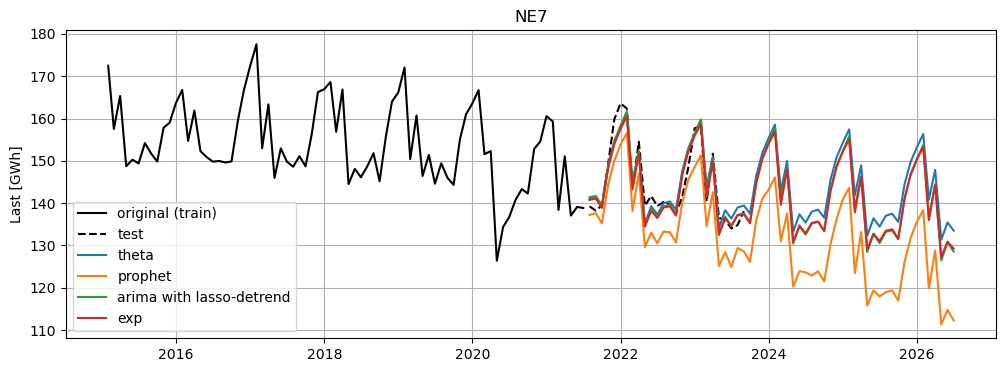

In [46]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.plot(y_train.index.to_timestamp(freq="M"), y_train.values, color="black", label="original (train)")
axes.plot(y_test.index, y_test.values, color="black",linestyle="--",label="test")

for key, value in five_years_predictions.items():
    axes.plot(value.index.to_timestamp(freq="M"), value.values, label=key)

#axes.plot(ensemble.predict(fh=horizon).index, ensemble.predict(fh=horizon).values, label="ensemble")
axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")
axes.grid()
plt.show()

In [47]:
#How to create an ensemble?

In [48]:
from scipy.optimize import minimize

df = pd.DataFrame(one_year_predictions)

def loss_func(weights):    
    fc = np.sum(df*np.array(weights),axis=1)
    return mean_squared_error(y_test.y.values,fc)

def loss_function(weights):
    #calculating the weighted average
    fc = np.sum(pred_wide[candidates].values*np.array(weights), axis=1)
    #using any metric function to calculate the loss
    return mean_squared_error(pred_wide['target'].values, fc)


opt_weights = minimize(loss_func, x0=[1/len(df.columns)]*len(df.columns),constraints=[{'type':'eq','fun':lambda w: 1-sum(w)}], method='SLSQP', bounds=[(0.0,1.0)]*len(df.columns),
options={'ftol':1e-10})

#create a dataframe with the optimized weights and the columnnames as df.columns
opt_weights_df = pd.DataFrame(opt_weights.x,index=df.columns,columns=['opt_weight'])
opt_weights_df


,opt_weight
theta,0.000000
prophet,0.000000
arima with lasso-detrend,0.667281
exp,0.332719
